In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/notebook
/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds


In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
#     "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
    "RU000A0JV4N8",
#     "RU000A0D0G29",
#     "RU000A0JPLH5",
#    "RU000A0JQ8V9",
#     "RU000A0JQAL8",
#     "RU000A0JQAM6",
    "RU000A0JQRD9",
    "RU000A0JWUB5",
#     "RU000A0JWUX9",
    "RU000A0JWV89",
#     "RU000A0JWVL2",
#     "RU000A0JWVT5",
#     "RU000A0JWWM8",
#     "RU000A0JWX04",
#     "RU000A0JWYJ0",
#     "RU000A0JWYQ5",
#     "RU000A0JWZY6",

#     "RU000A101MG4"
)

In [5]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        df_price = df_price.sort_index(level="date")
        all_dates=df_price.index.levels[0].unique()
        all_isins = df_price.index.levels[1].unique()
        new_index = pd.MultiIndex.from_product([all_dates, all_isins], names=['date', 'isin'])
        df_price_reindexed = df_price.reindex(new_index)
        self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')
        
        df_dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        df_dur["date"] = df_dur["date"].dt.date
        self._dur = df_dur.set_index(["date", "isin"]).sort_index(level="date")
#         all_dates_dur = pd.date_range(start=df_dur.index.levels[0].min(), end=df_dur.index.levels[0].max())
#         # Get all unique 'isin' values
#         all_isins_dur = df_dur.index.levels[1].unique()
#         full_index = pd.MultiIndex.from_product([all_dates_dur, all_isins_dur], names=['date', 'isin'])

#         # Remove entries from full_index that are already in df's index
#         new_index = full_index.difference(df_dur.index)

#         # Reindex the DataFrame with the new index
#         df_dur_reindexed = df_dur.reindex(df_dur.index.union(new_index))

#         # Fill missing values
#         self._dur = df_dur_reindexed.groupby(level='isin').fillna(method='ffill')
        
        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date
        self._rating["isin"] = self._rating["isincode"]

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")
        
    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]

bond_data = BondDataProvider()


/var/folders/47/m1n0krg53lbb1g1klf717_mr0000gp/T/ipykernel_70043/530856763.py:17: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')
/var/folders/47/m1n0krg53lbb1g1klf717_mr0000gp/T/ipykernel_70043/530856763.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self._price = df_price_reindexed.groupby(level='isin').fillna(method='ffill')


In [6]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

# Linear programming

In [7]:
from models.linear_programming import linear_minimize

In [8]:
# create portfolio for a linear programming optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [9]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-03-01"),
    bond_data.price.index.get_level_values(0).max(),
)
def get_data(date):
    today_bond_data = bond_data.price.loc[(date, slice(None)),]
    if len(today_bond_data) < len(port.bond_universe):
        return None
    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today is None or price_today.empty:
        return None   
    if len(price_today) < len(port.bond_universe):
        return None
    grouped_yield=bond_data.yield_.set_index(["date", "isin"])
    if not date in grouped_yield.index.get_level_values('date').date:
        print(0)
        return None   
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            grouped_yield.loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()
    today_info = today_info.join(rating_reduced)
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    rating_reduced = today_info["num_rating"]
    return today_info,price_today
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue
    raw_data=get_data(date)
    if raw_data is None:
        continue
    today_info,price_today=raw_data
    new_weights=linear_minimize(today_info, weight_at_least=0.1)
    
    if new_weights is None:
        print("No answer for you")
        
    print(new_weights)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-03-01
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0
cash = -2.220446049250313e-16
2023-03-02
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 0.9989023776531285
cash = -2.220446049250313e-16
2023-03-03
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0434120208481812
cash = -2.220446049250313e-16
2023-03-04
2023-03-05
2023-03-06
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.1]
wealth = 1.0477269185380846
cash = -2.220446049250313e-16
2023-03-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0485934995218995
cash = -2.220446049250313e-16
2023-03-08
2023-03-09
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.048759743836929
cash = -2.220446049250313e-16
2023-03-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0479822417732962
cash = -2.220446049250313e-16
2023-03-11
2023-03-12
2023-03-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0474227279023614
cash = -2.220446049250313e-16
2023-03-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0435847028792091
cash = -2.220446049250313e-1

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.026686400690266
cash = 0.0
2023-05-04
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0273020022636623
cash = -4.440892098500626e-16
2023-05-05
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0274199469651935
cash = -2.220446049250313e-16
2023-05-06
2023-05-07
2023-05-08
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0318942312253248
cash = -2.220446049250313e-16
2023-05-09
2023-05-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0290981789914688
cash = -2.220446049250313e-16
2023-05-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.027798368884786
cash = -2.220446049250313e-16
2023-05-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.027146039653257
cash = -2.220446049250313e-16
2023-05-13
2023-05-14
2023-05-15
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0288747613909979
cash = -2.220446049250313e-16
2023-05-16
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.029364477287101
cash = -2.220446049250313e-16
2023-05-17
[0.1 

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.04708190924781
cash = -2.220446049250313e-16
2023-07-06
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0423935972736864
cash = -2.220446049250313e-16
2023-07-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0488267047246116
cash = -2.220446049250313e-16
2023-07-08
2023-07-09
2023-07-10
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0455470577175934
cash = -2.220446049250313e-16
2023-07-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0478930561124142
cash = -2.220446049250313e-16
2023-07-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0474458702158398
cash = -2.220446049250313e-16
2023-07-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0461325687703487
cash = -2.220446049250313e-16
2023-07-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0481748382869929
cash = -2.220446049250313e-16
2023-07-15
2023-07-16
2023-07-17
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.039289995538095
cash = -2.220446049250313e-16
2023-07

[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0308923339817317
cash = -2.220446049250313e-16
2023-09-06
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0288306452962563
cash = -2.220446049250313e-16
2023-09-07
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.024896242467781
cash = -2.220446049250313e-16
2023-09-08
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0190803170474128
cash = -2.220446049250313e-16
2023-09-09
2023-09-10
2023-09-11
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0211663708046543
cash = -2.220446049250313e-16
2023-09-12
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0233378413489043
cash = -2.220446049250313e-16
2023-09-13
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0153674569438131
cash = -2.220446049250313e-16
2023-09-14
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0085176422689848
cash = -2.220446049250313e-16
2023-09-15
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1]
wealth = 1.0130476345070025
cash = -2.220446049250313e-16
2023-09-16
2023-09-17
2023-

In [10]:
wealth

1.0133830661083543

In [11]:
def get_weights(x):
    y=x*5
    z=x+2
    return y,z
print(get_weights(1)[0])

5


In [12]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [13]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

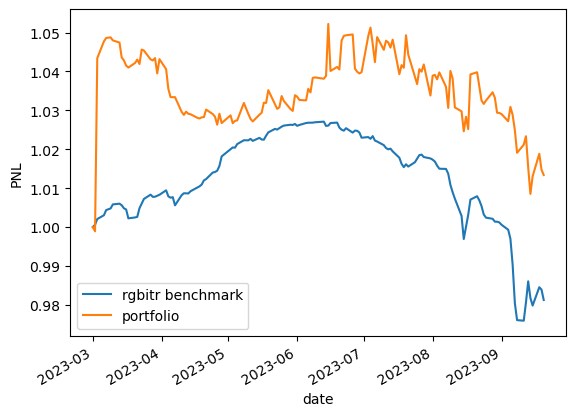

In [14]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")
plt.legend()
plt.ylabel("PNL");

### mean and median return

In [15]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

'Mean return = 0.000, Median return = -0.000'

## Sharpe Ratio

In [16]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [17]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

-0.0

### Information Ratio

In [18]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [19]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

-0.045956253424388645

## Returns

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

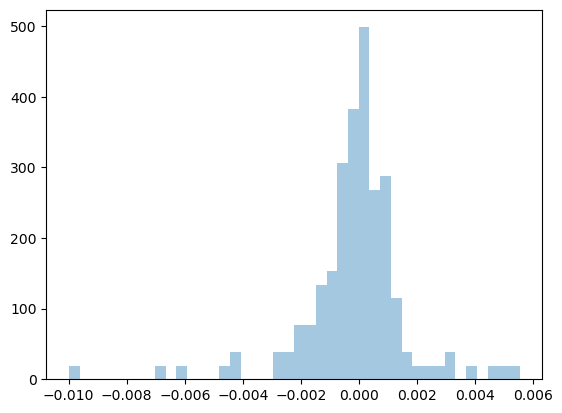

In [20]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

In [ ]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [ ]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [ ]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

## Value at Risk

In [ ]:
alpha = 0.05
returns_benchmark.quantile(alpha)

## Skewness of Returns

In [ ]:
alpha = 0.05
returns_benchmark.skew()